In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/'ANN2DL_submission'/

Mounted at /gdrive
/gdrive/My Drive/ANN2DL_submission


##Install Missing Libraries

In [2]:
!pip install visualkeras
import visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 7.2 MB/s eta 0:00:00


In [3]:
import tensorflow as tf
import cv2
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import shutil
from sklearn.model_selection import train_test_split
from PIL import Image
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
tfk = tf.keras
tfkl = tf.keras.layers


In [4]:
# Random seed for reproducibility and hide warnings
seed = 100

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

##Upload and visualize the dataset

In [ ]:
# Load the dataset to be used for classification
!unzip public_data.zip

Archive:  public_data.zip
replace public_data.npz? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [5]:
dataset_dir = np.load('public_data.npz',allow_pickle=True)
# Access the keys
lst = dataset_dir.files
images = dataset_dir['data']
labels = dataset_dir['labels']

# Convert values in data to int
images = images.astype(int)


###Necessary for a better visualisation of the the images and in order to rescale them





In [ ]:
def load_images_from_npz_load(images):
    images_return = []

    # Iterate through files in the specified folder
    for img in images:

        # Normalize image pixel values to a float range [0, 1]
        img = (img / 255).astype(np.float32)

        # Convert image from BGR to RGB
        #img = img[...,::-1]

        # Make the image dataset squared
        dim = min(img.shape[:-1])
        img = img[(img.shape[0]-dim)//2:(img.shape[0]+dim)//2, (img.shape[1]-dim)//2:(img.shape[1]+dim)//2, :]

        # Resize the image to 224x224 pixels
        #img = tfkl.Resizing(256, 256)(img)

        if img is not None:
            images_return.append(img)

    return np.array(images_return)

# Load images from the 'items/' folder
items = load_images_from_npz_load(images)


In [ ]:
num_row = 7
num_col = 3
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_row,9*num_col))
for i in range(num_row*num_col):
  if i < 21:
    class_img = labels[i]
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.clip(items[i], 0, 255))  # Display clipped item images
    ax.axis('off')
    ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

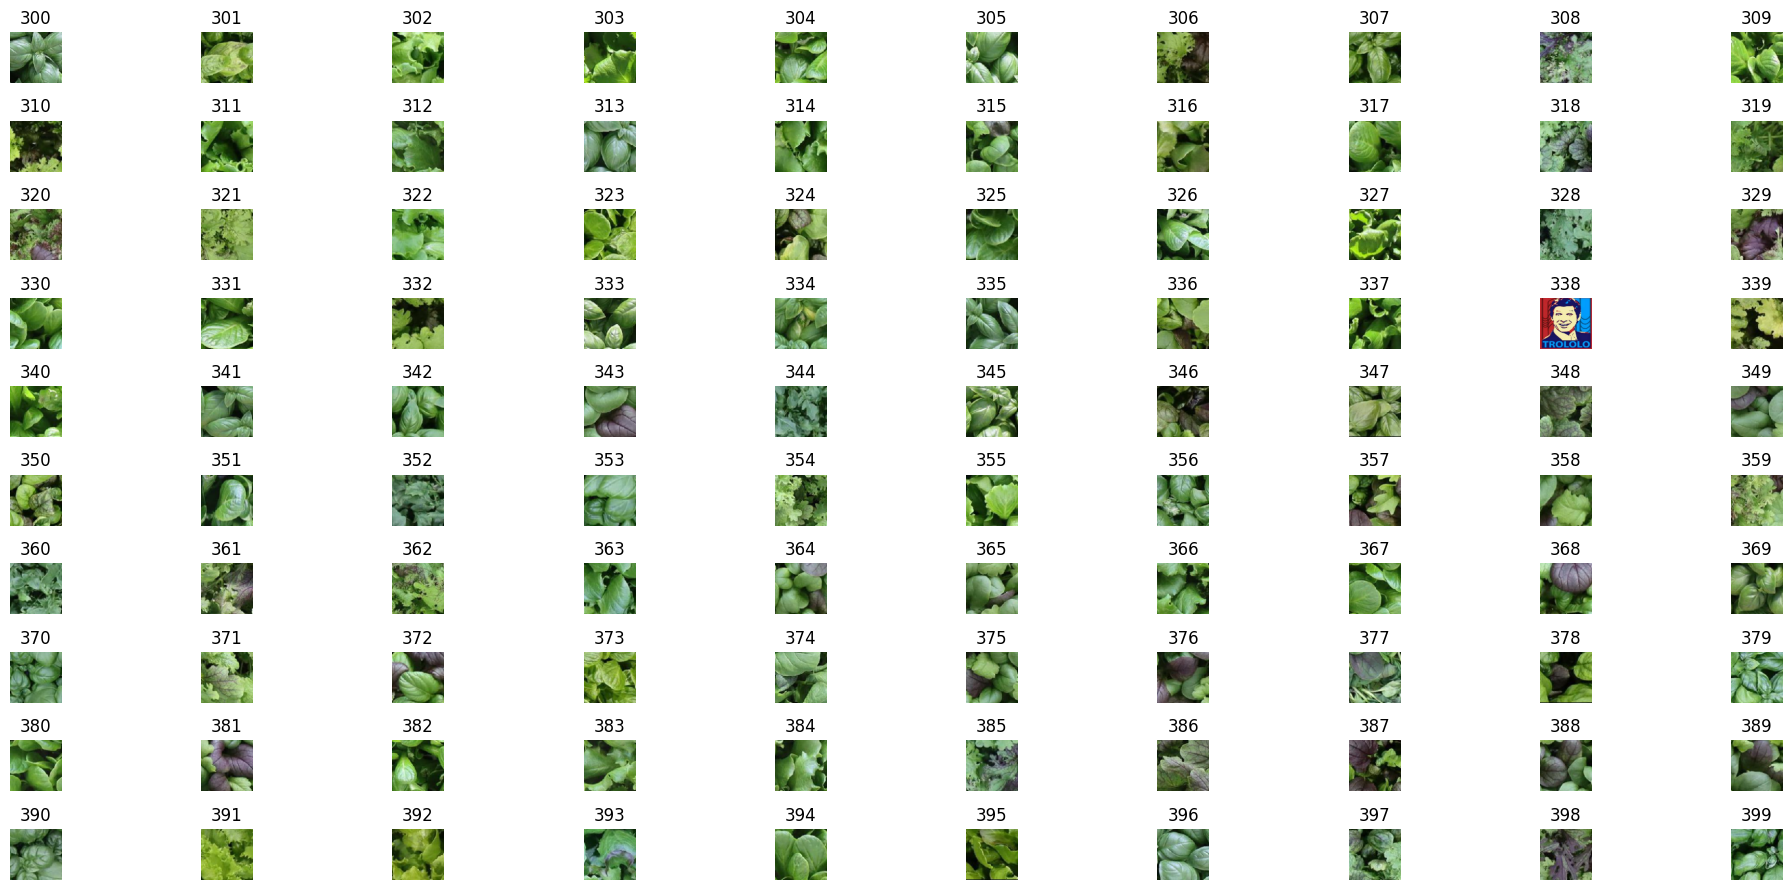

In [ ]:
# Visualize interval of 100 images
interval = 3 # first interval -> interval 0
n = 100
fig , axes = plt.subplots(int(n/10),10, figsize = (20,9))
axes = axes.reshape((-1,))
for i in range(n):
    axes[i].imshow(np.clip(images[(interval*n)+i],0,255))
    axes[i].axis('off')
    axes[i].set_title((interval*n)+i)

plt.tight_layout()

## Clean the dataset

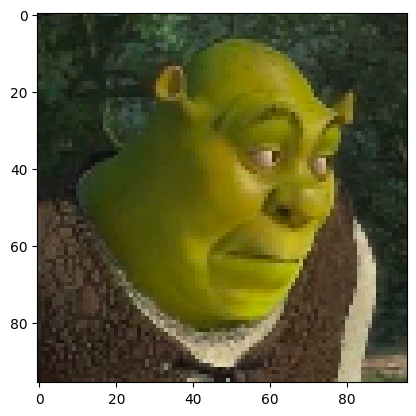

In [6]:
# Save bad images
shrek = images[58]
trololo = images[338]
plt.imshow(np.clip(shrek,0,255))

In [7]:
# Create the mask for bad images
shrek_mask = np.all(images == shrek, axis=(1, 2, 3))
unique_shrek, count_shrek = np.unique(shrek_mask, return_counts= True)
print("There are ", count_shrek[1], " shrek images")

trololo_mask = np.all(images == trololo, axis=(1, 2, 3))
unique_trololo, count_trololo = np.unique(trololo_mask, return_counts= True)
print("and ", count_trololo[1], " trololo images.")

mask_bad = np.logical_or(shrek_mask, trololo_mask)

There are  98  shrek images
and  98  trololo images.


In [8]:
# Delete bad images
images_leaves = images[np.logical_not(mask_bad)]
labels_leaves = labels[np.logical_not(mask_bad)]
print("There are ", len(images_leaves), " leaves images.")

There are  5004  leaves images.


In [9]:
# Find unique images
unique_images, indices_unique_images, count_unique_images = np.unique(images_leaves, return_index= True, return_counts= True, axis= 0)
print("There are ",len(count_unique_images), " unique images.")
images_unique = images_leaves[indices_unique_images]
labels_unique = labels_leaves[indices_unique_images]
labels_unique

There are  4850  unique images.


array(['healthy', 'healthy', 'unhealthy', ..., 'healthy', 'unhealthy',
       'unhealthy'], dtype=object)

In [10]:
# set the definitive dataset
X = images_unique
y = labels_unique

### Create train and validation sets

In [11]:
# Normalize data to the range [0, 1]
X_train_val = (X / 255).astype('float32')

# Create a mapping from label string to values
map = {'healthy':0 , 'unhealthy':1}

# Map labels from string to the corresponding encoding
int_labels = np.array([map[label] for label in y])
int_labels

array([0, 0, 1, ..., 0, 1, 1])

In [12]:
uniques, count = np.unique(int_labels, return_counts= True)
N_HEALTHY = count[0]
N_UNHEALTHY = count[1]
N_SAMPLES = N_HEALTHY + N_UNHEALTHY

print("The dataset contains:")
print(N_HEALTHY, " healthy samples")
print(N_UNHEALTHY, " unhealthy samples")
print("For a total of ", N_SAMPLES, " samples")

The dataset contains:
3060  healthy samples
1790  unhealthy samples
For a total of  4850  samples


In [13]:
# Convert labels to categorical format using one-hot encoding
y_train_val = tfk.utils.to_categorical(int_labels)
y_train_val

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [14]:
# Split data into training and validation sets, maintaining class distribution
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=0.1, stratify=y_train_val)

In [15]:
# Print the shapes of the resulting datasets
print("Training Data Shape:", X_train.shape)
print("Training Label Shape:", y_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Validation Label Shape:", y_val.shape)
print("\n")

# Compare categorical label and "default" label representation
print('Categorical label:', y_train[0])           # Display the categorical label
print('"Default" label:', np.argmax(y_train[0]))   # Display t

Training Data Shape: (4365, 96, 96, 3)
Training Label Shape: (4365, 2)
Validation Data Shape: (485, 96, 96, 3)
Validation Label Shape: (485, 2)


Categorical label: [1. 0.]
"Default" label: 0


In [16]:
# Define key model parameters
input_shape = X_train.shape[1:]     # Input shape for the model
output_shape = y_train.shape[1]     # Output shape for the model
batch_size = 32                    # Batch size for training
epochs = 500                        # Number of training epochs

# Print the defined parameters
print("Epochs:\t\t", epochs)
print("Batch Size:\t", batch_size)
print("Input Shape:\t", input_shape)
print("Output Shape:\t", output_shape)



Epochs:		 500
Batch Size:	 32
Input Shape:	 (96, 96, 3)
Output Shape:	 2


###Models with and without DataAugmentation

In [ ]:
# Home directory
home_path ='/gdrive/MyDrive/ANN2DL_submission/public_data/Splitting_ImageGenerator'
# Create train and validation directories
train_path = os.path.join(home_path,'train')
os.mkdir(train_path)
val_path = os.path.join(home_path,'valid')
os.mkdir(val_path)

# Create sub-directories
healthy_train_path = os.path.join(home_path + r'/train','healthy')
os.mkdir(healthy_train_path)

unhealthy_train_path = os.path.join(home_path + r'/train','unhealthy')
os.mkdir(unhealthy_train_path)

healthy_val_path = os.path.join(home_path + r'/valid','healthy')
os.mkdir(healthy_val_path)

unhealthy_val_path = os.path.join(home_path + r'/valid','unhealthy')
os.mkdir(unhealthy_val_path)

In [ ]:
# Save train images
for i in range(len(y_train)):
    image = X_train[i] * 255
    image = Image.fromarray(np.uint8(image), 'RGB')
    if y_train[i][-1] == 1:
        file_path = f'/content/public_data/train/unhealthy/unhealthy{i}.jpg'
    else:
        file_path = f'/content/public_data/train/healthy/healthy{i}.jpg'
    try:
        image.save(file_path, format='JPEG', quality=80)
    except Exception as e:
        print(f"Errore durante il salvataggio dell'immagine {j}: {str(e)}")


In [ ]:
# Save validation images
for j in range(len(y_val)):
    image = X_val[j] * 255
    image = Image.fromarray(np.uint8(image), 'RGB')
    if y_val[j][-1] == 1:
        file_path = f'/content/public_data/valid/unhealthy/unhealthy{j}.jpg'
    else:
        file_path = f'/content/public_data/valid/healthy/healthy{j}.jpg'
    try:
        image.save(file_path, format='JPEG', quality=80)
    except Exception as e:
        print(f"Errore durante il salvataggio dell'immagine {j}: {str(e)}")


In [ ]:
shutil.move('/content/public_data/train', '/gdrive/My Drive')

'/gdrive/My Drive/valid'

In [ ]:
shutil.move('/content/public_data/valid', '/gdrive/My Drive')

'/gdrive/My Drive/valid'

###First Model - Accuracy 0.6 in the test set

In [ ]:
def build_model(input_shape=input_shape, output_shape=output_shape):
    tf.random.set_seed(seed)

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    conv1 = tfkl.Conv2D(
        filters=32,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(input_layer)
    pool1 = tfkl.MaxPooling2D()(conv1)

    conv2 = tfkl.Conv2D(
        filters=64,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool1)
    pool2 = tfkl.MaxPooling2D()(conv2)

    conv3 = tfkl.Conv2D(
        filters=128,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool2)
    pool3 = tfkl.MaxPooling2D()(conv3)

    conv4 = tfkl.Conv2D(
        filters=256,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool3)
    pool4 = tfkl.MaxPooling2D()(conv4)

    conv5 = tfkl.Conv2D(
        filters=512,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool4)
    pool5 = tfkl.MaxPooling2D()(conv5)

    flattening_layer = tfkl.Flatten(name='Flatten')(pool5)
    dropout = tfkl.Dropout(0.3, seed=seed)(flattening_layer)
    classifier_layer = tfkl.Dense(units=512, name='Classifier', kernel_initializer=tfk.initializers.HeUniform(seed), activation='relu')(dropout)
    dropout = tfkl.Dropout(0.3, seed=seed)(classifier_layer)
    output_layer = tfkl.Dense(units=output_shape, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='output_layer')(dropout)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

###Second Model-Accuracy in the test set ...

In [ ]:
def build_model(input_shape = input_shape, output_shape = output_shape,  seed=seed):
    tf.random.set_seed(seed)
    preprocessing = tf.keras.Sequential([
        tfkl.RandomBrightness(0.5, value_range=(0,1)),
        tfkl.RandomZoom(0.2, fill_mode='reflect'),
        tfkl.RandomFlip("horizontal"),
        tfkl.RandomRotation(0.2),
        tfkl.RandomTranslation(0.2,0.2,fill_mode='reflect'),
    ], name='preprocessing')


    # Build the discriminator layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')
    preprocessing = preprocessing(input_layer)
    x = tfkl.ZeroPadding2D((2,2), name='padding')(input_layer)
    #ZeroPadding used to achieve a deeper convolutional neural network
    x = tfkl.Conv2D(32, 3, padding='same', strides=2, name='conv1')(x)
    x = tfkl.BatchNormalization(name='bn')(x)
    #BatchNormalization layer used to have a more robust and faster tranning;
    x = tfkl.LeakyReLU(alpha=0.2, name='activation')(x)
    #We try to solve the problem of vanish gradient
    x = tfkl.MaxPooling2D( pool_size =(2,2), strides = 2, padding = 'same', name='mp1')(x)
    x = tfkl.Dropout(0.2, seed = seed)(x)

    x = tfkl.Conv2D(64, 3, padding='same', strides=2, name='conv2')(x)
    x = tfkl.BatchNormalization(name='bn1')(x)
    #BatchNormalization layer used to have a more robust and faster tranning;
    x = tfkl.LeakyReLU(alpha=0.2, name='activation1')(x)
    #We try to solve the problem of vanish gradient
    x = tfkl.MaxPooling2D( pool_size =(2,2), strides = 2, padding = 'same', name='mp2')(x)
    x = tfkl.Dropout(0.2, seed = seed)(x)

    x = tfkl.Conv2D(128, 3, padding='same', strides=2, name='conv3')(x)
    x = tfkl.BatchNormalization(name='bn2')(x)
    x = tfkl.LeakyReLU(alpha=0.2, name='activation2')(x)
    x = tfkl.MaxPooling2D( pool_size =(2,2), strides = 2, padding = 'same', name='mp3')(x)
    x = tfkl.Dropout(0.2, seed = seed)(x)

    x = tfkl.Conv2D(256, 3, padding='same', strides=2, name='conv4')(x)
    x = tfkl.BatchNormalization(name='bn3')(x)
    x = tfkl.LeakyReLU(alpha=0.2, name='activation3')(x)
    x = tfkl.MaxPooling2D( pool_size =(2,2), strides = 2, padding = 'same', name='mp4')(x)
    x = tfkl.Dropout(0.2, seed = seed)(x)

    x = tfkl.Conv2D(512, 3, padding='same', strides=2, name='conv5')(x)
    x = tfkl.BatchNormalization(name='bn4')(x)
    x = tfkl.LeakyReLU(alpha=0.2, name='activation4')(x)
    x = tfkl.MaxPooling2D( pool_size =(2,2), strides = 2, padding = 'same', name='mp5')(x)
    x = tfkl.Dropout(0.2, seed = seed)(x)

    x = tfkl.GlobalAveragePooling2D(name='gap')(x)
    x = tfkl.Dropout(.3, seed=seed, name='dropout1')(x)
    x = tfkl.Dense(64, name='dense1')(x)
    x = tfkl.Activation('softmax', name='activationD1')(x)
    x = tfkl.Dropout(.3, seed=seed, name='dropout')(x)
    x = tfkl.Dense(output_shape, name='dense2')(x)
    output_layer = tfkl.Activation('softmax', name='activationD2')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='BGAP')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])
    # Return the discriminator
    return model

Model: "BGAP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 96, 96, 3)]       0         
                                                                 
 padding (ZeroPadding2D)     (None, 100, 100, 3)       0         
                                                                 
 conv1 (Conv2D)              (None, 50, 50, 32)        896       
                                                                 
 bn (BatchNormalization)     (None, 50, 50, 32)        128       
                                                                 
 activation (LeakyReLU)      (None, 50, 50, 32)        0         
                                                                 
 mp1 (MaxPooling2D)          (None, 25, 25, 32)        0         
                                                                 
 dropout_13 (Dropout)        (None, 25, 25, 32)        0      

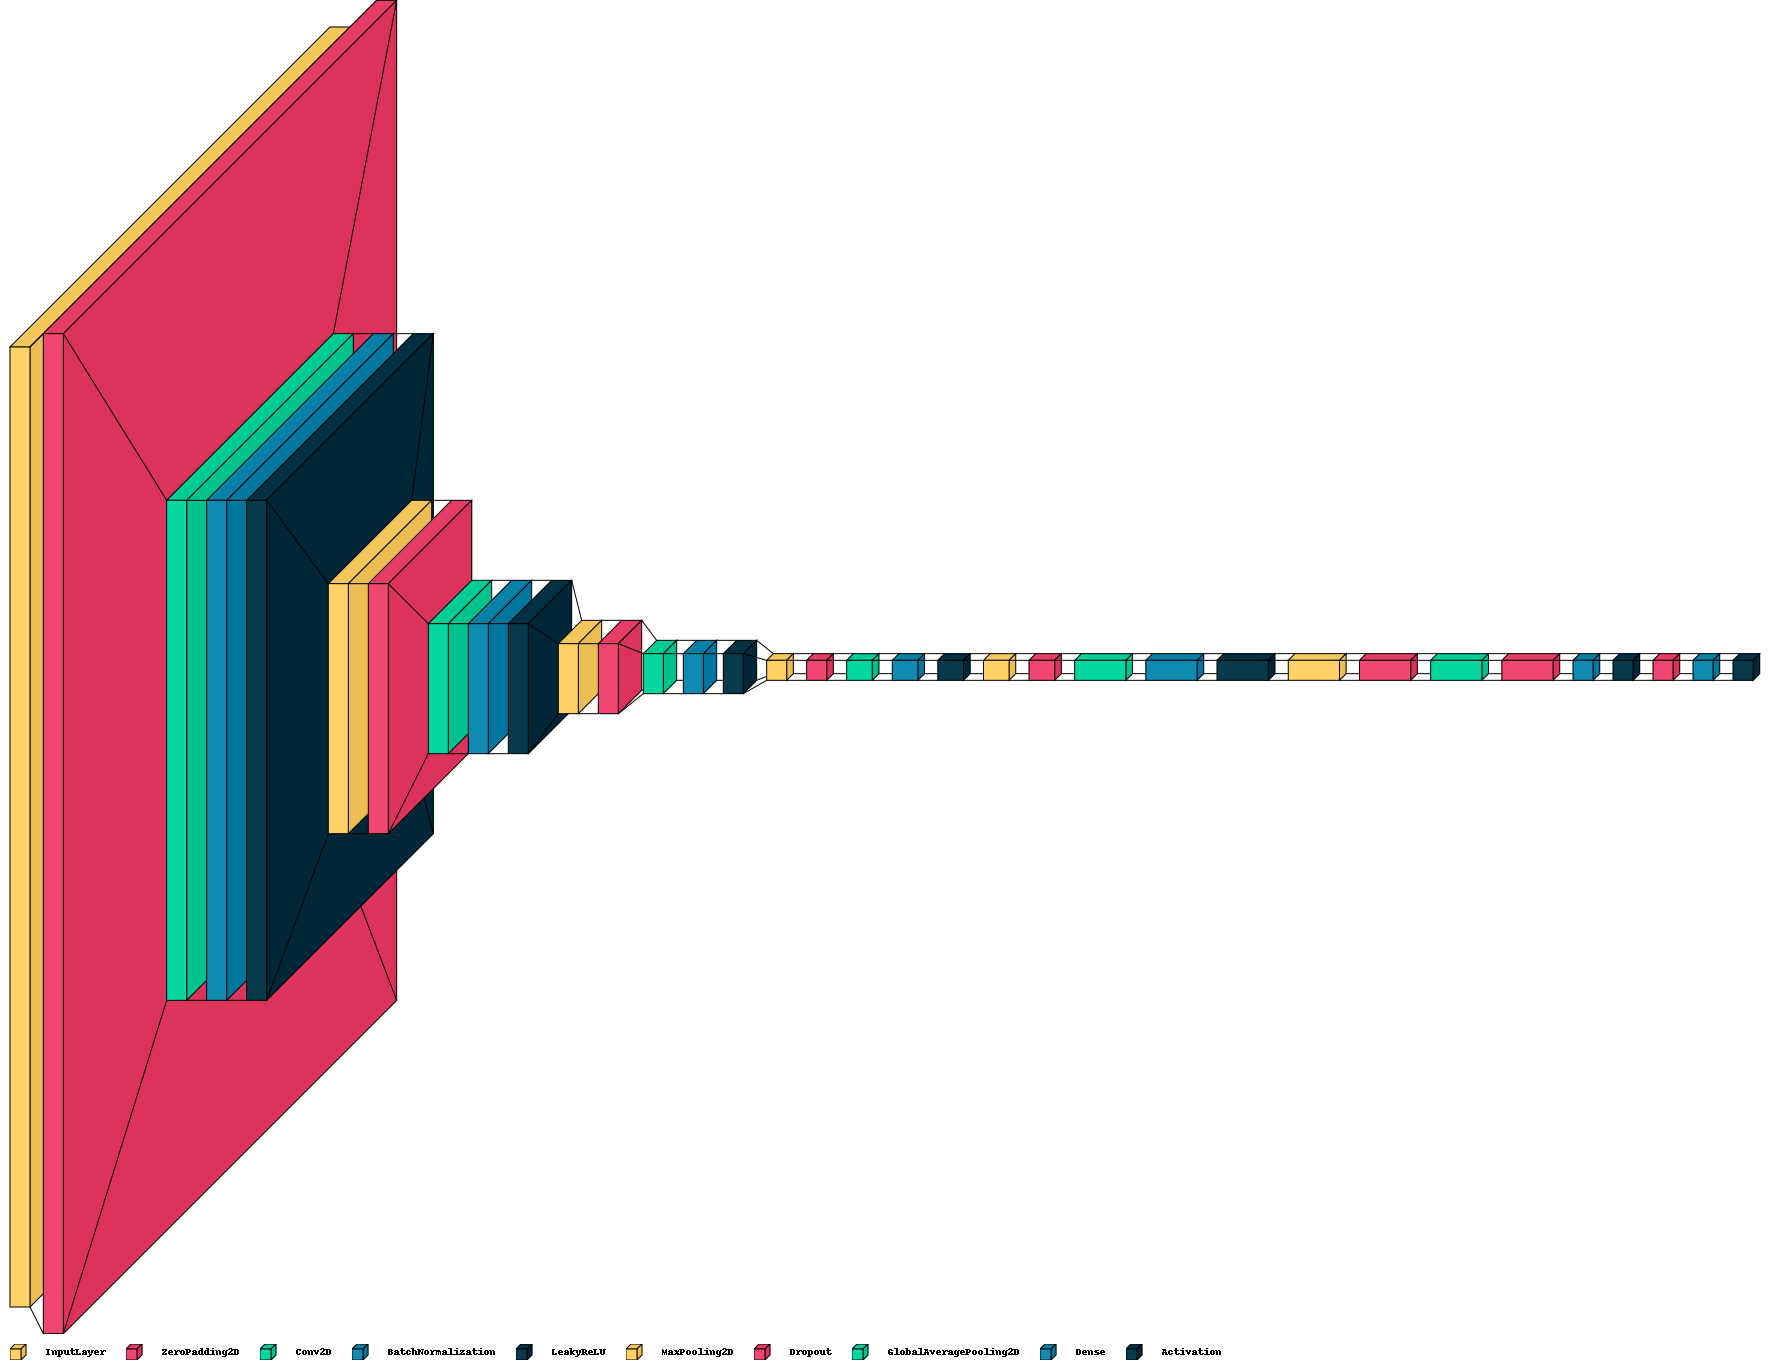

In [ ]:
model = build_model()
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True )
display(visualkeras.layered_view(model, legend=True, spacing=20, scale_xy=10))

In [ ]:
# Train the model and save its history
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    verbose = 0
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=150, restore_best_weights=True)]
).history

Epoch 1/500
122/122 [==============================] - 18s 27ms/step - loss: 0.6613 - accuracy: 0.6253 - val_loss: 0.6585 - val_accuracy: 0.6309
Epoch 2/500
122/122 [==============================] - 2s 14ms/step - loss: 0.6424 - accuracy: 0.6387 - val_loss: 0.6617 - val_accuracy: 0.6309
Epoch 3/500
122/122 [==============================] - 1s 12ms/step - loss: 0.6461 - accuracy: 0.6454 - val_loss: 0.6651 - val_accuracy: 0.6309
Epoch 4/500
122/122 [==============================] - 1s 12ms/step - loss: 0.6318 - accuracy: 0.6639 - val_loss: 0.6565 - val_accuracy: 0.6423
Epoch 5/500
122/122 [==============================] - 1s 12ms/step - loss: 0.6175 - accuracy: 0.6688 - val_loss: 0.6502 - val_accuracy: 0.6928
Epoch 6/500
122/122 [==============================] - 1s 12ms/step - loss: 0.6208 - accuracy: 0.6680 - val_loss: 0.6486 - val_accuracy: 0.6464
Epoch 7/500
122/122 [==============================] - 1s 12ms/step - loss: 0.6080 - accuracy: 0.6704 - val_loss: 0.6048 - val_accuracy

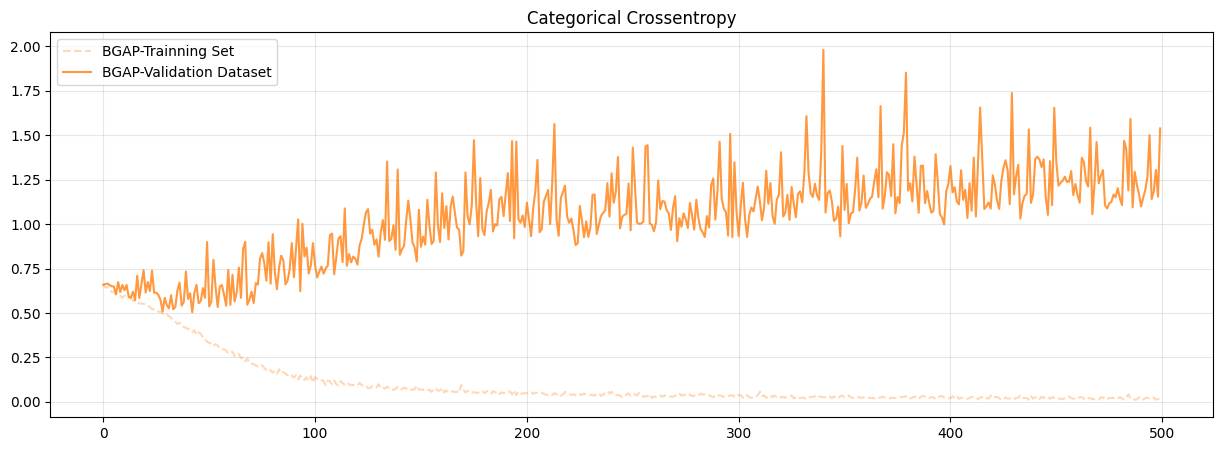

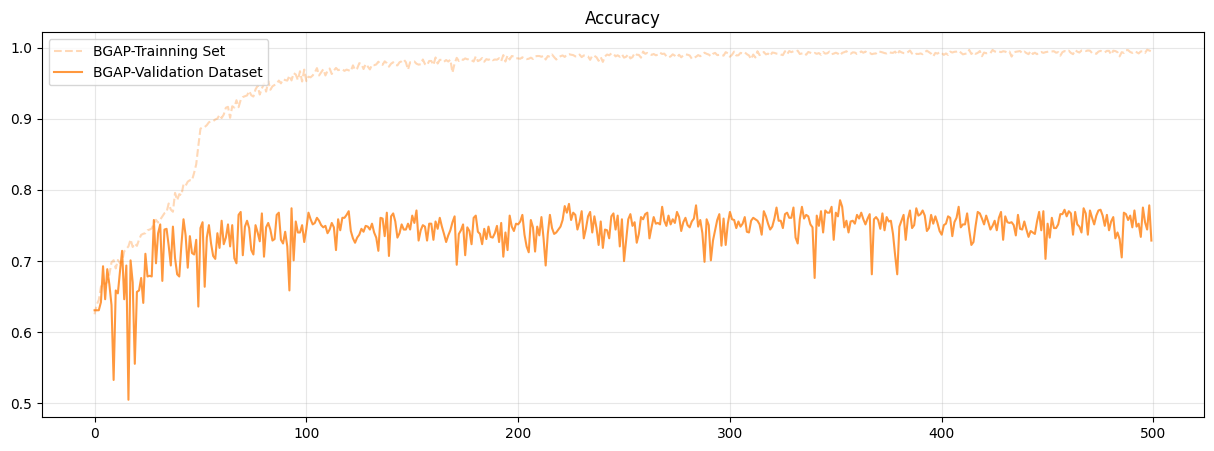

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label = 'BGAP-Trainning Set' ,alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='BGAP-Validation Dataset', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label = 'BGAP-Trainning Set' , alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='BGAP-Validation Dataset', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# Save the trained model
model.save("saved_model_name")

###Third Model

In [22]:
home_path ='/gdrive/MyDrive'
training_dir = os.path.join(home_path, 'train')
validation_dir = os.path.join(home_path, 'valid')

valid_data_gen = ImageDataGenerator(rescale=1/255.)
valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=False,
                                               seed=seed)

Found 495 images belonging to 2 classes.


In [23]:
# Create an instance of ImageDataGenerator with Data Augmentation
aug_train_data_gen = ImageDataGenerator(rotation_range=30,
                                        height_shift_range=.5,
                                        width_shift_range=.5,
                                        zoom_range=0.3,
                                        horizontal_flip=True,
                                        vertical_flip=True,
                                        fill_mode='reflect',
                                        rescale=1/255.) # rescale value is multiplied to the image

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(96,96),
                                                       color_mode='rgb',
                                                       classes=None, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=8,
                                                       shuffle=True,
                                                       seed=seed)

Found 4359 images belonging to 2 classes.


In [24]:
def build_model(input_shape = input_shape, output_shape = output_shape,  seed=seed):
    tf.random.set_seed(seed)
    elastic_lambda = 1e-5

    # Build the discriminator layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')
    x = tfkl.ZeroPadding2D((2,2), name='padding')(input_layer)
    #ZeroPadding used to achieve a deeper convolutional neural network
    x = tfkl.Conv2D(32, 3, padding='same', strides=2, name='conv1')(x)
    x = tfkl.BatchNormalization(name='bn')(x)
    #BatchNormalization layer used to have a more robust and faster tranning;
    x = tfkl.LeakyReLU(alpha=0.2, name='activation')(x)
    #We try to solve the problem of vanish gradient
    x = tfkl.MaxPooling2D( pool_size =(2,2), strides = 2, padding = 'same', name='mp1')(x)
    x = tfkl.Dropout(0.2, seed = seed)(x)

    x = tfkl.Conv2D(64, 3, padding='same', strides=2, name='conv2')(x)
    x = tfkl.BatchNormalization(name='bn1')(x)
    #BatchNormalization layer used to have a more robust and faster tranning;
    x = tfkl.LeakyReLU(alpha=0.2, name='activation1')(x)
    #We try to solve the problem of vanish gradient
    x = tfkl.MaxPooling2D( pool_size =(2,2), strides = 2, padding = 'same', name='mp2')(x)
    x = tfkl.Dropout(0.2, seed = seed)(x)

    x = tfkl.Conv2D(128, 3, padding='same', strides=2, name='conv3')(x)
    x = tfkl.BatchNormalization(name='bn2')(x)
    x = tfkl.LeakyReLU(alpha=0.2, name='activation2')(x)
    x = tfkl.MaxPooling2D( pool_size =(2,2), strides = 2, padding = 'same', name='mp3')(x)
    x = tfkl.Dropout(0.2, seed = seed)(x)

    x = tfkl.Conv2D(256, 3, padding='same', strides=2, name='conv4')(x)
    x = tfkl.BatchNormalization(name='bn3')(x)
    x = tfkl.LeakyReLU(alpha=0.2, name='activation3')(x)
    #x = tfkl.MaxPooling2D( pool_size =(2,2), strides = 2, padding = 'same', name='mp4')(x)
    x = tfkl.Dropout(0.2, seed = seed)(x)

    x = tfkl.Conv2D(512, 3, padding='same', strides=2, name='conv5')(x)
    x = tfkl.BatchNormalization(name='bn4')(x)
    x = tfkl.LeakyReLU(alpha=0.2, name='activation4')(x)
    #x = tfkl.MaxPooling2D( pool_size =(2,2), strides = 2, padding = 'same', name='mp5')(x)
    x = tfkl.Dropout(0.2, seed = seed)(x)

    x = tfkl.GlobalAveragePooling2D(name='gap')(x)
    x = tfkl.Dropout(.3, seed=seed, name='dropout1')(x)
    x = tfkl.Dense(units=64, activation='relu', name='DenseHidden1',
                               kernel_initializer=tfk.initializers.HeUniform(seed=seed),
                               kernel_regularizer=tf.keras.regularizers.L1L2(elastic_lambda,elastic_lambda))(x)
    x = tfkl.Dropout(.3, seed=seed, name='dropout2')(x)
    x = tfkl.Dense(units=32, activation='relu', name='HiddenDense2',
                               kernel_initializer=tfk.initializers.HeUniform(seed=seed),
                               kernel_regularizer=tf.keras.regularizers.L1L2(elastic_lambda,elastic_lambda))(x)
    x = tfkl.Dropout(.3, seed=seed, name='dropout3')(x)
    x = tfkl.Dense(output_shape, name='HiddenDense3')(x)
    output_layer = tfkl.Activation('softmax', name='activationD2')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])
    # Return the discriminator
    return model

In [30]:
def build_model(input_shape = input_shape, seed = seed):

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    conv1 = tfkl.Conv2D(
        filters=32,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(input_layer)
    pool1 = tfkl.MaxPooling2D()(conv1)

    conv2 = tfkl.Conv2D(
        filters=64,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool1)
    pool2 = tfkl.MaxPooling2D()(conv2)

    conv3 = tfkl.Conv2D(
        filters=128,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool2)
    pool3 = tfkl.MaxPooling2D()(conv3)

    conv4 = tfkl.Conv2D(
        filters=256,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool3)
    pool4 = tfkl.MaxPooling2D()(conv4)

    conv5 = tfkl.Conv2D(
        filters=512,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool4)
    pool5 = tfkl.MaxPooling2D()(conv5)

    x= tfkl.Dropout(0.2, seed = seed)(pool5)

    x = tfkl.GlobalAveragePooling2D(name='gap')(x)
    dropout = tfkl.Dropout(0.3, seed=seed)(x)
    classifier_layer = tfkl.Dense(units=512, name='Classifier', kernel_initializer=tfk.initializers.HeUniform(seed), activation='relu')(dropout)
    dropout = tfkl.Dropout(0.3, seed=seed)(classifier_layer)
    output_layer = tfkl.Dense(units=2, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='output_layer')(dropout)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 96, 96, 3)]       0         
                                                                 
 padding (ZeroPadding2D)     (None, 100, 100, 3)       0         
                                                                 
 conv1 (Conv2D)              (None, 50, 50, 32)        896       
                                                                 
 bn (BatchNormalization)     (None, 50, 50, 32)        128       
                                                                 
 activation (LeakyReLU)      (None, 50, 50, 32)        0         
                                                                 
 mp1 (MaxPooling2D)          (None, 25, 25, 32)        0         
                                                                 
 dropout_5 (Dropout)         (None, 25, 25, 32)        0     

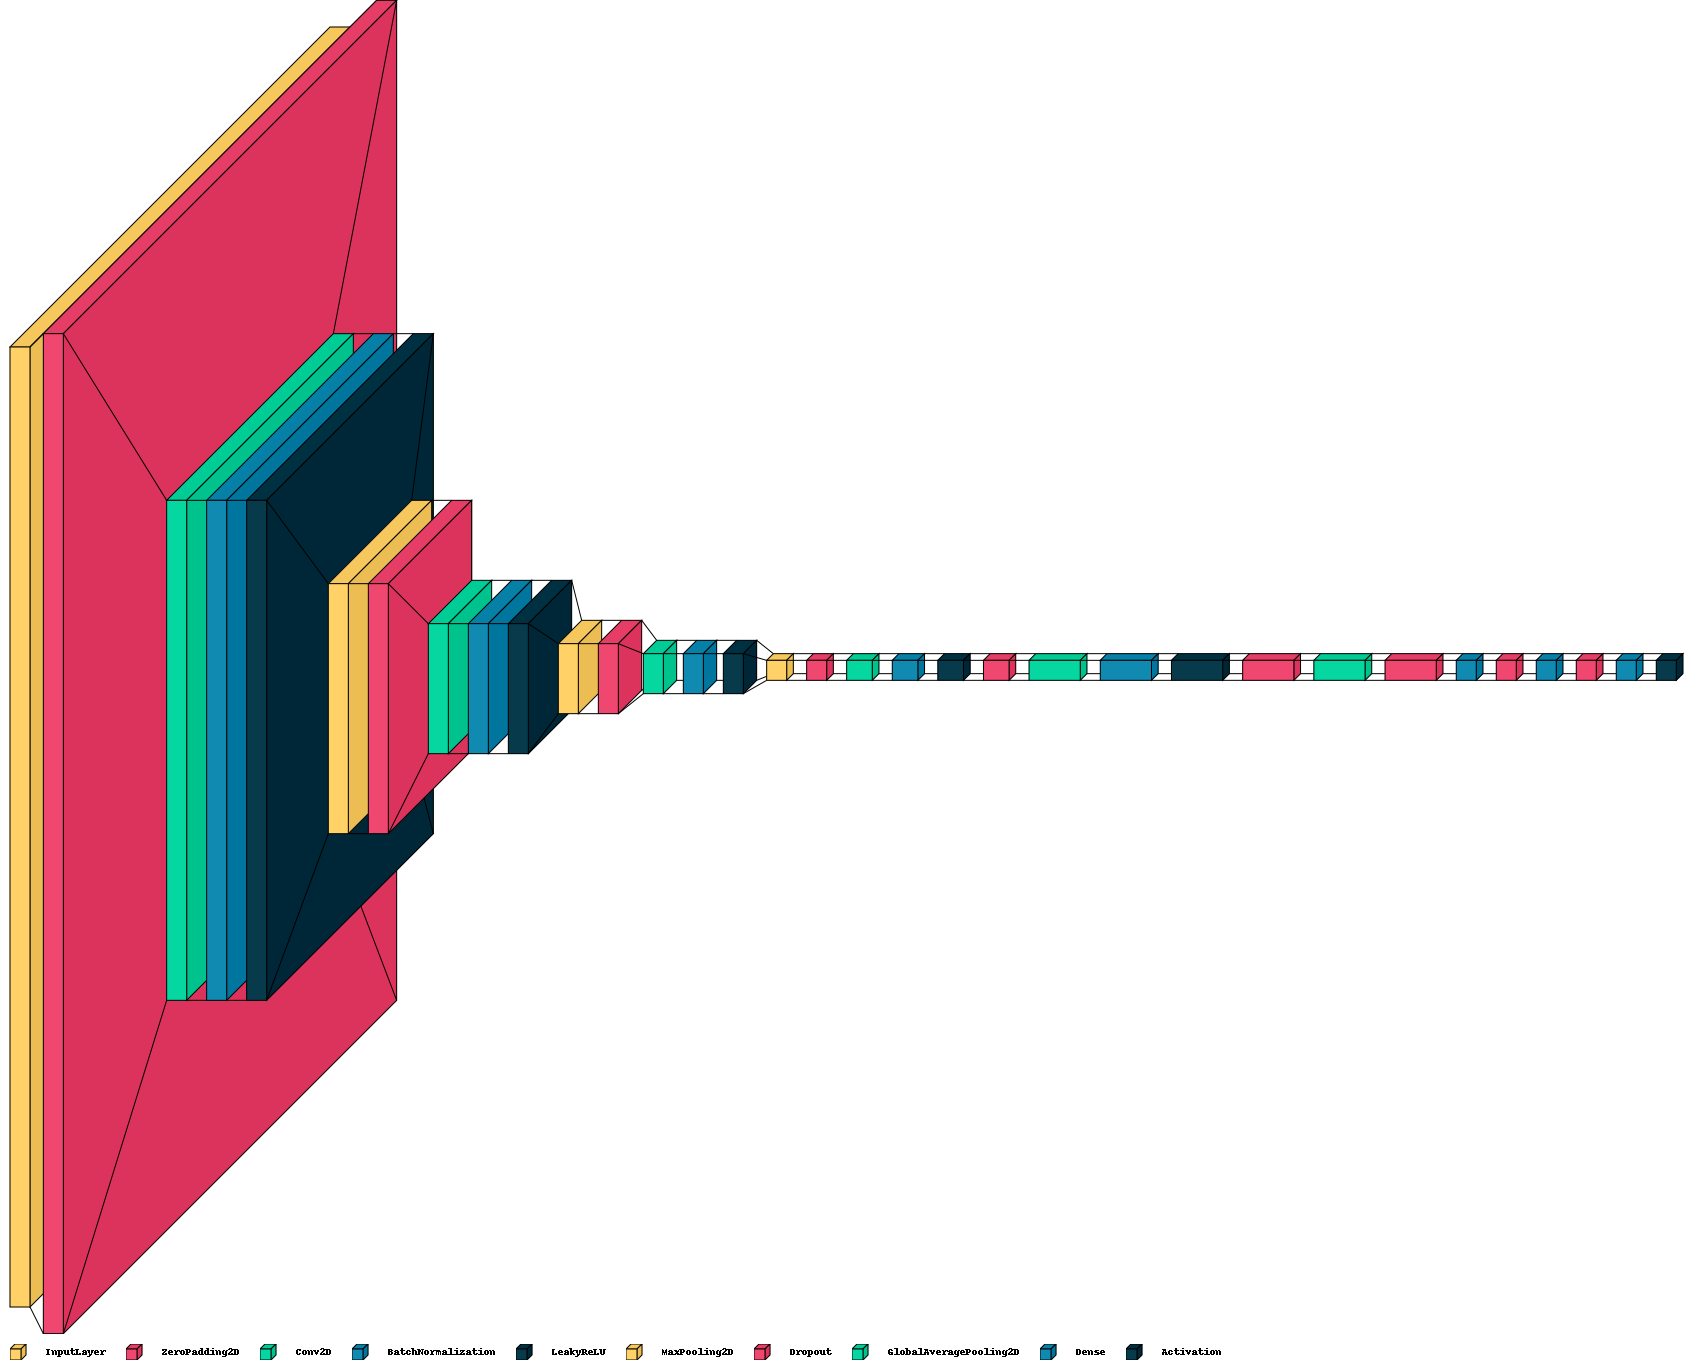

In [25]:
model = build_model()
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True )
display(visualkeras.layered_view(model, legend=True, spacing=20, scale_xy=10))

In [26]:
# Train the model and save its history
history = model.fit(
    x = aug_train_gen,
    epochs=epochs,
    validation_data= valid_gen,
    verbose = 1,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=150, restore_best_weights=True)]
).history

Epoch 1/500
545/545 [==============================] - 423s 747ms/step - loss: 0.7919 - accuracy: 0.5937 - val_loss: 0.6569 - val_accuracy: 0.6384
Epoch 2/500
545/545 [==============================] - 24s 44ms/step - loss: 0.6880 - accuracy: 0.6242 - val_loss: 0.6542 - val_accuracy: 0.6384
Epoch 3/500
545/545 [==============================] - 23s 43ms/step - loss: 0.6784 - accuracy: 0.6311 - val_loss: 0.6709 - val_accuracy: 0.6384
Epoch 4/500
545/545 [==============================] - 26s 48ms/step - loss: 0.6651 - accuracy: 0.6391 - val_loss: 0.6532 - val_accuracy: 0.6707
Epoch 5/500
545/545 [==============================] - 24s 44ms/step - loss: 0.6574 - accuracy: 0.6437 - val_loss: 0.6595 - val_accuracy: 0.6384
Epoch 6/500
545/545 [==============================] - 24s 44ms/step - loss: 0.6564 - accuracy: 0.6435 - val_loss: 0.6240 - val_accuracy: 0.6808
Epoch 7/500
545/545 [==============================] - 24s 44ms/step - loss: 0.6516 - accuracy: 0.6472 - val_loss: 0.6399 - val_

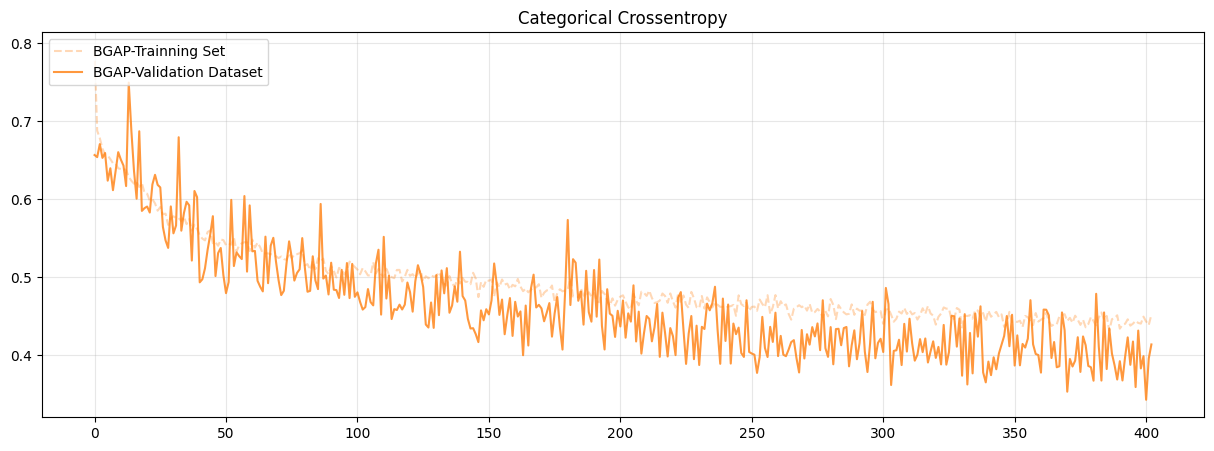

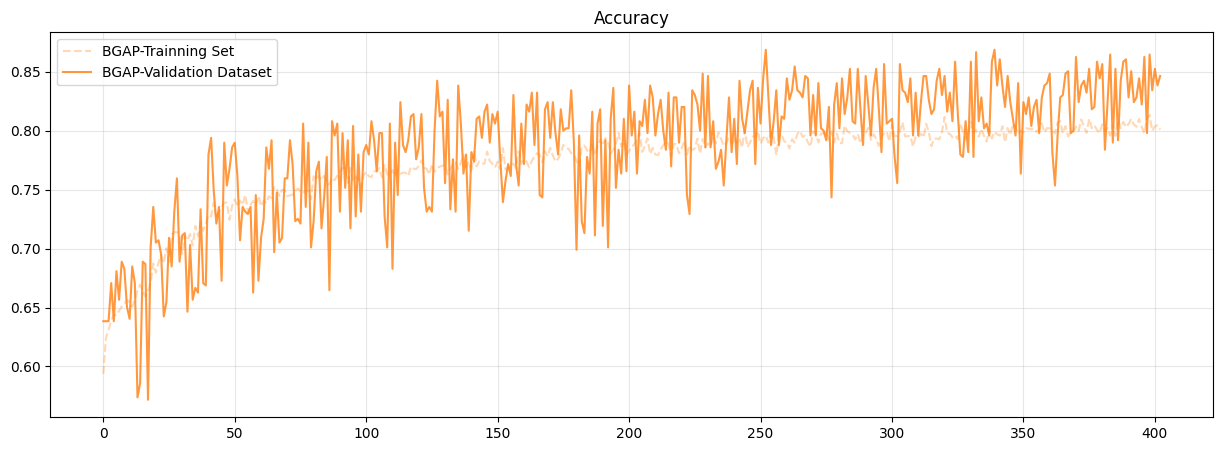

In [27]:
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label = 'BGAP-Trainning Set' ,alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='BGAP-Validation Dataset', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label = 'BGAP-Trainning Set' , alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='BGAP-Validation Dataset', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [28]:
# Save the trained model
model.save("saved_model_name")